In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
PATH_DATA='../data/raw/'
PATH_DATA_INTERIM='../data/interim/'

In [4]:
df1 = pd.read_csv(PATH_DATA_INTERIM+'iter1_interim_cln.csv')

In [5]:
df1.sample()

,id,time,street,median_length,median_delay,median_speed_kmh,total_records,level,time2,hours,...,streettime2,is_train,weekendmean,weekendstd,weekdaysmean,weekdaysstd,weekdaysmean69,weekdaysstd69,weekdaysmean1518,weekdaysstd1518
35027,34879612,2022-07-28 06:00:00.000,N9 Jalan Raya Dramaga,877.0,651.0,4.73,15,4,2022-07-28 06:00:00,6,...,N9 Jalan Raya Dramaga_2022-07-28 06:00:00.000,1,0.0,0.0,2.693182,0.9512,2.693182,0.9512,0.0,0.0


In [6]:
col_used = list(set(df1.columns)-set(['id','is_train','level','time','time2','street','streettime','streettime2']))

col_used.sort() ## --> remember to sort

In [7]:
Xtrain = df1[df1.is_train == 1][col_used]
Ytrain = df1[df1.is_train == 1]['level']

Xtest = df1[df1.is_train == 0][col_used]
Ytest = df1[df1.is_train == 0]['level']

In [8]:
Ytrain.mean(), Ytest.mean()

(2.4188851447968864, 2.429523525315826)

Transformation

In [9]:
SS = StandardScaler()

In [10]:
SS.fit(Xtrain)
Xtrain_ss = pd.DataFrame(SS.transform(Xtrain), columns = col_used)
Xtest_ss = pd.DataFrame(SS.transform(Xtest), columns = col_used)

In [11]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
#store data, all in numpy arrays
training_data = {'X_train':Xtrain_ss,'Y_train':Ytrain,
                'X_test': Xtest_ss,'Y_test':Ytest}

In [12]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [13]:
clf = RandomForestClassifier(n_jobs=None,random_state=27, verbose=1)
clf.fit(training_data['X_train'], training_data['Y_train'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.0s finished


RandomForestClassifier(random_state=27, verbose=1)

In [14]:
predicted_labels = clf.predict(training_data['X_test'])
accuracy_score(training_data['Y_test'], predicted_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


0.8338306973042873

In [15]:
params = {
    'n_estimators'      : [1000, 1100],
    'max_depth'         : [29, 30, 31],
    'max_features': ['auto'],
    'criterion' :['entropy']
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator = clf, param_grid = params, scoring='f1_micro',n_jobs=3,verbose = 10, cv=5)
gsearch1.fit(training_data['X_train'], training_data['Y_train'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=27, verbose=1),
             n_jobs=3,
             param_grid={'criterion': ['entropy'], 'max_depth': [29, 30, 31],
                         'max_features': ['auto'],
                         'n_estimators': [1000, 1100]},
             scoring='f1_micro', verbose=10)

In [16]:
print(getTrainScores(gsearch1))
finalmodel = gsearch1.best_estimator_

({0: "mean:0.8517339261077044params{'criterion': 'entropy', 'max_depth': 29, 'max_features': 'auto', 'n_estimators': 1000}", 1: "mean:0.8517712202110816params{'criterion': 'entropy', 'max_depth': 29, 'max_features': 'auto', 'n_estimators': 1100}", 2: "mean:0.8522064098206208params{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 1000}", 3: "mean:0.8521691133980547params{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 1100}", 4: "mean:0.8519452977556359params{'criterion': 'entropy', 'max_depth': 31, 'max_features': 'auto', 'n_estimators': 1000}", 5: "mean:0.8517960942849232params{'criterion': 'entropy', 'max_depth': 31, 'max_features': 'auto', 'n_estimators': 1100}"}, {'best_mean': 0.8522064098206208, 'best_param': {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 1000}})


In [17]:
finalmodel.fit(training_data['X_train'], training_data['Y_train'])
predicted_labels =finalmodel.predict(training_data['X_test'])
train_pred = finalmodel.predict(training_data['X_train'])
print('Train Accuracy:'+str(accuracy_score(training_data['Y_train'], train_pred)))
print('Train F1-Score(Micro):'+str(f1_score(training_data['Y_train'], train_pred,average='micro')))
print('------')
print('Test Accuracy:'+str(accuracy_score(training_data['Y_test'], predicted_labels)))
print('Test F1-Score(Micro):'+str(f1_score(training_data['Y_test'], predicted_labels,average='micro')))

c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train Accuracy:1.0
Train F1-Score(Micro):1.0
------
Test Accuracy:0.8378096090719188
Test F1-Score(Micro):0.8378096090719188


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.8s finished


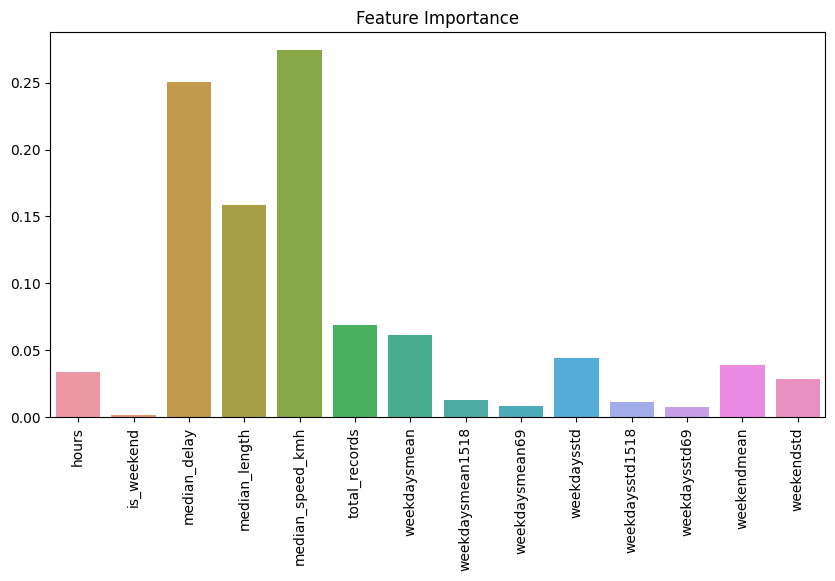

In [18]:
features=Xtrain_ss.columns
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=finalmodel.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

In [19]:
print('Classification report:\n', classification_report(training_data['Y_test'], predicted_labels))
conf_mat = confusion_matrix(training_data['Y_test'], predicted_labels)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           1       0.84      0.83      0.84      3891
           2       0.82      0.83      0.83      7080
           3       0.84      0.83      0.83      6072
           4       0.87      0.85      0.86      2734
           5       1.00      1.00      1.00       329

    accuracy                           0.84     20106
   macro avg       0.87      0.87      0.87     20106
weighted avg       0.84      0.84      0.84     20106

Confusion matrix:
 [[3246  618   21    6    0]
 [ 594 5903  568   15    0]
 [  32  677 5045  318    0]
 [   5   25  382 2322    0]
 [   0    0    0    0  329]]
